# Analyze A/B Test Results 

This project aligns with the mastery of the subjects covered in the statistics lessons. I have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability


In [1]:
#import the necessary libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

%xmode Plain
# %pdb on
# %xmode Verbose
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Exception reporting mode: Plain


In [2]:
# Read in the dataset from the `ab_data.csv` file and take a look at the top few rows
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# Find the number of rows in the dataset
df.shape[0]

294478

In [4]:
# The number of unique users in the dataset
df.user_id.nunique()

290584

In [5]:
# The proportion of users converted
converted = df.query('converted == 1').count()[0]
converted/df.shape[0]

0.11965919355605512

In [6]:
# The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`
misline1 = df.query('group == "treatment" and landing_page == "old_page"')
misline1.shape[0]

1965

In [7]:
# missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64



How should we handle the rows where the group and landing_page columns don't match?

Create a new dataset that meets the specifications.  Store new dataframe in **df2**.

In [8]:
# Find inaccurate rows for control group that landed on a new page
misline2 = df.query('group == "control" and landing_page == "new_page"')
misline2.shape[0]

1928

In [9]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.drop(misline1.index, axis=0)
df2 = df2.drop(misline2.index, axis=0)
df2.shape[0]

290585

In [10]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [11]:
# Find out how many unique user_ids are in df2
df2.user_id.nunique()

290584

In [12]:
# There is one user_id repeated in df2
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
# Display the rows for the duplicate user_id
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [14]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 

# Check again if the row with a duplicate user_id is deleted or not
df2 = df2.drop([df.index[2893]], inplace=False)
df2.shape[0]

290584



**What is the probability of an individual converting regardless of the page they receive?**


In [15]:
p_pop = df2.query('converted == 1').count()[0]/df2.shape[0]
p_pop

0.11959708724499628

**Given that an individual was in the `control` group, what is the probability they converted?**

In [16]:
#P(Convert|control)
p_cont = df2.query('group == "control" and converted == 1').count()[0]/df2.query('group == "control"').count()[0]
p_cont

0.1203863045004612

**Given that an individual was in the `treatment` group, what is the probability they converted?**

In [17]:
#P(Convert|treatment)
p_treat = df2.query('group == "treatment" and converted == 1').count()[0]/df2.query('group == "treatment"').count()[0]
p_treat

0.11880806551510564

In [18]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = p_treat - p_cont
obs_diff

-0.0015782389853555567

**What is the probability that an individual received the new page?**

In [19]:
df2.query('landing_page == "new_page"').count()[0]/df2.shape[0]

0.5000619442226688

**Did the new `treatment` group users lead to more conversions?**

><span style="color: darkblue;">There is not sufficient evidence that new treatment page leads to more conversions. An individual had 50% of chance to land a new page, and 50% to land an old page. Out of both groups that was in control and treatment almost same proportion of people either converted or did not regardless wether they were on the new webpage or old. Although, people who had access to old page actually had a slightly higher conversion rate. Based on this finding there is not enough evidence that suggests the new webpage is any better than the old.</span>

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

State your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

<center>
<span style="color: darkblue;"> H<sub>0</sub>: p<sub>new</sub> - p<sub>old</sub> <= 0<br>
H<sub>1</sub>: p<sub>new</sub> - p<sub>old</sub> > 0</span>
    </center>

### Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>


**What is the conversion rate for $p_{new}$ under the null hypothesis?**

In [20]:
#same for new_page and old_page
p_new = df2.converted.mean()
p_new

0.11959708724499628

**What is the conversion rate for $p_{old}$ under the null hypothesis?** 

In [21]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

**What is $n_{new}$, the number of individuals in the treatment group?** <br>
The treatment group users are shown the new page.

In [22]:
n_new = df2.query('landing_page == "new_page"').count()[0]
n_new

145310

**What is $n_{old}$, the number of individuals in the control group?**

In [23]:
n_old = df2.query('group == "control"').count()[0]
n_old

145274

**Simulate Sample for the `treatment` Group** 


In [24]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
new_page_converted.mean()

0.11958248296744889

**Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [25]:
# Simulate a Sample for the control Group
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old
old_page_converted.mean()

0.1195947044894475

**Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for simulated sample.** 

In [26]:
p_conv = new_page_converted.mean() - old_page_converted.mean()
p_conv

-1.2221521998617701e-05


**Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times. 

<br>


In [27]:
# Sampling distribution 
p_diffs = []

new_page_converted = np.random.binomial(n_new, p_new, 10000)/n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000)/n_old

p_diffs = new_page_converted - old_page_converted 
p_diffs = np.array(p_diffs)


**Plot a histogram of the **p_diffs**.
Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


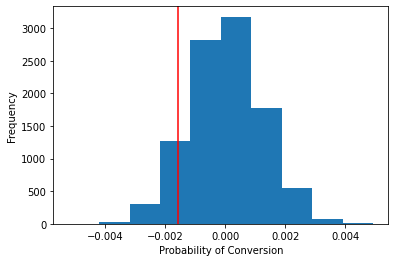

In [28]:
plt.hist(p_diffs)
plt.axvline(obs_diff, color='red')
plt.xlabel("Probability of Conversion")
plt.ylabel("Frequency");

**What proportion of the p_diffs are greater than the actual difference observed in the `df2` data?**

In [29]:
p_diffs.mean(), obs_diff.mean()

(2.6268301848746234e-05, -0.0015782389853555567)

In [30]:
(p_diffs>obs_diff).mean()

0.9098


**What does this value signify in terms of whether or not there is a difference between the new and old pages? Compare the value above with the "Type I error rate (0.05)".** 

><span style="color: darkblue;"> The calculation above calculation 0.9076 is the p-value. This p-value is far above the 0.05 Type I error rate(or significance level). At this signifance level we fail to reject the Null Hypothesis. Which means 90.76% percent of the time we would expect that random chance can provide us the same observed result.</span>



**Using Built-in Methods for Hypothesis Testing**


In [31]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('landing_page == "old_page" and converted == 1').count()[0]

# number of conversions with the new_page
convert_new = df2.query('landing_page == "new_page" and converted ==  1').count()[0]

# number of individuals who were shown the old_page
n_old 

# number of individuals who received new_page
n_new 

145310

In [32]:
convert_old, convert_new

(17489, 17264)

In [33]:
n_old, n_new

(145274, 145310)

In [34]:
z_score,p_value= sm.stats.proportions_ztest(count=[convert_new,convert_old], nobs=[n_new,n_old], alternative='larger')
z_score,p_value

(-1.3109241984234394, 0.9050583127590245)

**Use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.** 

In [35]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(count=[convert_new,convert_old], nobs=[n_old,n_new], alternative='larger')
print(z_score, p_value)

-1.2616957421858055 0.8964708551967226


**What do the z-score and p-value you computed in the previous mean for the conversion rates of the old and new pages?**


><span style="color: darkblue;"> P-value in both calculations is aproximately 0.90. Since Z-score(-1.26) is not greater than z-critical value(1.96), we fail to reject the Null Hypothesis again. So at 5% significance level, there is no statistical evidence that the new page yields to more conversion than the old page.</span>

<a id='regression'></a>
### Part III - A regression approach


>**Logistic regression model.**

In [36]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**The goal is to use statsmodels library to fit the regression model you specified above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:**
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [37]:
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1


**Use statsmodels to instantiate your regression model on the two columns created, then fit the model to predict whether or not an individual converts.** 


In [38]:
# instantiate the regression model
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

**Provide the summary of your model below.**

In [39]:
# summary of model
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 12 Jul 2022   Pseudo R-squ.:               8.077e-06
Time:                        15:40:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**What is the p-value associated with ab_page? Why does it differ from the value you found in Part II?**  


><span style="color: darkblue;">The p-value associated with ab_page is 0.190. It is larger than 0.05, so we fail to reject Null Hypothesis.<br>
Since Regression models are two tailed, our Null and Alternative Hypothesis for the Regression Model is:**<br>

><span style="color: darkblue;">**H<sub>0</sub>: p<sub>new</sub> - p<sub>old</sub> = 0**<br>
    **H<sub>1</sub>: p<sub>new</sub> - p<sub>old</sub> != 0**<br></span>
    
><span style="color: darkblue;">In both part II and III our dependent variable is 'conversion'. In Part II, our Hypothesis was one-sided. We looked at if there was a significant difference in conversion rates between users that used a new page to the old page. In Part III, using Regression analysis we looked at if the difference in conversion rates of new and old pages equal to zero, using two-sided hypothesis.</span>

**Why is it a good idea to consider other factors to add into the regression model.  Are there any disadvantages to adding additional terms into the regression model?**

><span style="color: darkblue;"> In situations where a test reveals that your practical expectations were incorrect, you can try to find other variables that might have influenced the outcome. Therefore adding other factors to the model can shed more light to the problem. However, the more variables added, the less reliable some of the calculations can be, since we can not isolate the relationship to only two variables.</span>

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 Provide the statistical output as well as a written response to answer this question.

In [40]:
# Read the countries.csv
df_countries = pd.read_csv('countries.csv')
# df_countries.head()

In [41]:
# Join with the df2 dataframe
df_merged = df2.set_index('user_id').join(df_countries.set_index('user_id'))
df_merged.head()

,timestamp,group,landing_page,converted,ab_page,intercept,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,0,1,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,0,1,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,0,1,US


In [42]:
# Create the necessary dummy variables
df_merged[['UK', 'US', 'CA']] = pd.get_dummies(df_merged['country'])
# df_merged.head()

In [43]:
log_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'US', 'UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Jul 2022   Pseudo R-squ.:               2.323e-05
Time:                        15:40:40   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0099      0.013      0.743      0.457      -0.016       0.036
UK            -0.0408      0.027     -1.516      0.130      -0.093       0.012
==============================================================================
"""

In [44]:
np.exp(results.params)

intercept    0.136795
ab_page      0.985168
US           1.009932
UK           0.960062
dtype: float64

In [45]:
1/0.960062

1.0415993967056294

><span style="color: darkblue;">Looking closely on coefficients, we can conclude that US user conversion is 1.009 times more likely to happen compared to UK user conversion. And, UK user conversion is 1.04 times more likely to happen compared to US user conversion, holding all other variables constant.<br>
P-values are all above 0.05 significance level, which indicates there is not enough evidence to show a relation between user conversion and country.</span>

**h. Fit the model and obtain the results**<br> 
Though I have now looked at the individual factors of country and page on conversion, I would now like to look at an interaction between page and country to see if are there significant effects on conversion.


Provide the summary results (statistical output), and the conclusions based on the results. 

In [46]:
df_merged['ab_page_US'] = df_merged['ab_page']* df_merged['US'] 
df_merged['ab_page_UK'] = df_merged['ab_page']* df_merged['UK'] 

In [47]:
# Fit your model, and summarize the results
log_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'ab_page_US', 'ab_page_UK', 'US', 'UK']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Tue, 12 Jul 2022   Pseudo R-squ.:               3.482e-05
Time:                        15:40:41   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
ab_page_US     0.0314      0.027      1.181      0.238      -0.021       0.084
ab_page_UK    -0.0469      0.054     -0.872      0.383      -0.152       0.059
US            -0.0057      0.019     -0.306      0.760      -0.043       0.031
UK            -0.0175      0.038     -0.465      0.642      -0.091       0.056
==============================================================================
"""

In [48]:
np.exp(results.params)

intercept     0.137178
ab_page       0.979646
ab_page_US    1.031896
ab_page_UK    0.954198
US            0.994272
UK            0.982625
dtype: float64

In [49]:
 1/(0.954198), 1/0.994272, 1/0.982625

(1.0480005198082578, 1.005760999002285, 1.017682228724081)

><span style="color: darkblue;">P-values of interaction rates we looked at(0.238, 0.383, 0.760, 0.642) are higher than 0.05 signifance rate, which indicates the interaction rates are not significant enough to predict user conversion no matter which country the user is in.<br> 
Looking at coefficients, we can conclude US user new page increase is 1.03 times more likely than UK user new page increase, UK user new page increase is 1.017 times more likely than US user new page increase.</span>

### Looking at effect of 'time' on conversion

In [50]:
from datetime import datetime

df_merged['Date'] = pd.to_datetime(df_merged['timestamp']).dt.date
df_merged['Time'] = pd.to_datetime(df_merged['timestamp']).dt.time
df_merged['hour'] = pd.to_datetime(df_merged['timestamp']).dt.hour

In [51]:
# function to seperate night and day hours
def day_night(hours):
  if hours >=18 or hours < 6:
    return 'night'
  if hours >=6 or hours <18:
    return 'day'

In [52]:
# apply the function to seperate day/night
df_merged['day_night'] = df_merged['hour'].apply(day_night)
# df_merged.sample(1)

In [53]:
#create dummy variables for day/night
df_merged[['day','night']] = pd.get_dummies(df_merged['day_night'])
df_merged.sample(1)

,timestamp,group,landing_page,converted,ab_page,intercept,country,UK,US,CA,ab_page_US,ab_page_UK,Date,Time,hour,day_night,day,night
user_id,,,,,,,,,,,,,,,,,,
859255,2017-01-10 16:42:31.544217,control,old_page,0,0,1,UK,0,1,0,0,0,2017-01-10,16:42:31.544217,16,day,1,0


In [54]:
# fit the model
log_mod = sm.Logit(df_merged['converted'], df_merged[['intercept', 'US', 'UK','hour','day']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366100
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            4
Date:                Tue, 12 Jul 2022   Pseudo R-squ.:               5.979e-05
Time:                        15:40:43   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.01272
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0312      0.013   -154.383      0.000      -2.057      -2.005
US             0.0100      0.013      0.753      0.452      -0.016       0.036
UK            -0.0407      0.027     -1.513      0.130      -0.093       0.012
hour           0.0022      0.001      2.676      0.007       0.001       0.004
day            0.0176      0.011      1.536      0.124      -0.005       0.040
==============================================================================
"""

><span style="color: darkblue;"> P-value for hour is lower than 0.05 significance, which indicates there could be a relation between conversion and hour. However, time of day p-value is not conclusive.</span>

### Conclusion

><span style="color: darkblue;">To find out if a new web page has better conversion than the old web page, I first looked at a Probability model. In this model I looked at whether there was a significant difference in observed conversion between users that used the new page and users that used the old page. The result did not indicate a major difference between the two groups. I proceeded to perform an AB test simulating probabilites of conversion of users that used the new webpage and the old page, then compared it to my probability model. The results did not show any significant differences between the two groups.<br> </span>

><span style="color: darkblue;">Finally I performed a Logistic regression model, after merging the dataframe with the countries dataframe in order to compare user conversion of each country, then user new page interaction in each country. None of the results showed significant enough relatonships to predict user conversion in a country, or user new page interaction leading to conversion in any of the countries. I also ran a logistic model based on hour, which showed there was a relation indicating that hour might be related to conversion. However, when I broke it down to different hour segments of day and night, the p-value did not show any significant relationship. A more detailed analysis by hour might shed more light on conversion by hour.<br>


><span style="color: darkblue;">Over all, since most of the tests did not indicate that there was greater conversion for the new web page than the old web page, we cannot conclude that there will be any added benefit to implementing the new web page. However, the data collected was only from 23 days, and perhaps a longer running test would give a more definitive answer.</span>

### Resources<br>
<a href="https://stackoverflow.com/">Stack Overflow</a><br>
<a href="https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html">Scikit Learn</a><br>
<a href="https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.binomial.html">Scipy.org</a><br>